#Boston 311 v5 - Checking Label Outliers, and creating a cutoff

This notebook is similar to v4, because we are keeping the basic structure of our models and data cleaning functions, but focusing now on the label outliers. Some cases might be closed after weeks or months, and it would be interesting to see if we can find a meaninful cutoff where it appears cases might be autoclosed, or closed even if there's no resolution.

Related to that, cases that have not been open for very long probably shouldn't be part of our model training, since they are the cases we want to predict for. We should probably limit our models to cases that could have been resolved if given enough attention. We certainly wouldn't want to train our model on cases open in the last week or so for that reason.

Below is our open questions and to-dos consolidated from the last notebook. Moving forward we will probably keep this list at the top of each notebook.

##Questions and To-Dos from v4:

1. Train the models on all the historical 311 data - DONE
2. Add more features
3. clean up the data by removing outliers
4. deal with the missing feature columns between 2022 and 2023 data because some categorical feature values are missing from one or the other, resulting in one hot encoded column mismatches.
5. Develop some heuristics to see if our Machine Learning model can actually do better than some obvious correlations.
6. look at the currently available android app and see what values are available to the user to select, and which categories might be assigned by the 311 agents after receiving a new case.
7. compare a basic model which only uses the department value as a feature to our more complex models as a heuristic for whether additional features actually improve predictions.

Questions to answer:
1. Can we find some basic commonality between open cases?
2. When and how is the target date set? How about the overdue flag?
3. Do cases autoclose after a certain time?
4. Do cases carry over from year to year? If so, do they keep the same case_enquiry_id? (probably they do, but it would be good to confirm)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import glob
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime

from IPython.display import display

%matplotlib inline

#first of course we must import the necessary modules

Let's add some code to load the records directly from their storage so we don't have to upload them to google colaboratory each time. So far the URLs appear to be constant.

In [ ]:
url_2023 = "https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/e6013a93-1321-4f2a-bf91-8d8a02f1e62f/download/tmp9g_820k8.csv"
url_2022 = "https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/81a7b022-f8fc-4da5-80e4-b160058ca207/download/tmph4izx_fb.csv"
url_2021 = "https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/f53ebccd-bc61-49f9-83db-625f209c95f5/download/tmppgq9965_.csv"
url_2020 = "https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/6ff6a6fd-3141-4440-a880-6f60a37fe789/download/script_105774672_20210108153400_combine.csv"
url_2019 = "https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/ea2e4696-4a2d-429c-9807-d02eb92e0222/download/311_service_requests_2019.csv"
url_2018 = "https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/2be28d90-3a90-4af1-a3f6-f28c1e25880a/download/311_service_requests_2018.csv"
url_2017 = "https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/30022137-709d-465e-baae-ca155b51927d/download/311_service_requests_2017.csv"
url_2016 = "https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/b7ea6b1b-3ca4-4c5b-9713-6dc1db52379a/download/311_service_requests_2016.csv"
url_2015 = "https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/c9509ab4-6f6d-4b97-979a-0cf2a10c922b/download/311_service_requests_2015.csv"
url_2014 = "https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/bdae89c8-d4ce-40e9-a6e1-a5203953a2e0/download/311_service_requests_2014.csv"
url_2013 = "https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/407c5cd0-f764-4a41-adf8-054ff535049e/download/311_service_requests_2013.csv"
url_2012 = "https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/382e10d9-1864-40ba-bef6-4eea3c75463c/download/311_service_requests_2012.csv"
url_2011 = "https://data.boston.gov/dataset/8048697b-ad64-4bfc-b090-ee00169f2323/resource/94b499d9-712a-4d2a-b790-7ceec5c9c4b1/download/311_service_requests_2011.csv"


In [ ]:
def clean_and_split_for_logistic(myData) :

  data = myData.copy()
  # Convert the 'open_dt' and 'close_dt' columns to datetime
  data['open_dt'] = pd.to_datetime(data['open_dt'])
  data['closed_dt'] = pd.to_datetime(data['closed_dt'])
  data['survival_time'] = data['closed_dt'] - data['open_dt']
  data['event'] = data['closed_dt'].notnull().astype(int)
  data['ward_number'] = data['ward'].str.extract(r'0*(\d+)')

  cols_to_keep = ['case_enquiry_id', 'survival_time', 'event', 'subject', 'reason', 'department', 'source', 'ward_number']
  clean_data = data[cols_to_keep].copy()

  clean_data = pd.get_dummies(clean_data, columns=['subject', 'reason', 'department', 'source', 'ward_number'])

  #fix this line to also drop the case_enquiry_id
  X = clean_data.drop(['case_enquiry_id','event', 'survival_time'], axis=1)
  y = clean_data['event']

  return X, y

def clean_and_split_for_linear(myData) :

  data = myData.copy()
  # Convert the 'open_dt' and 'close_dt' columns to datetime
  data['open_dt'] = pd.to_datetime(data['open_dt'])
  data['closed_dt'] = pd.to_datetime(data['closed_dt'])
  data['survival_time'] = data['closed_dt'] - data['open_dt']
  data['event'] = data['closed_dt'].notnull().astype(int)
  data['ward_number'] = data['ward'].str.extract(r'0*(\d+)')

  cols_to_keep = ['case_enquiry_id', 'survival_time', 'event', 'subject', 'reason', 'department', 'source', 'ward_number']
  clean_data = data[cols_to_keep].copy()

  clean_data = pd.get_dummies(clean_data, columns=['subject', 'reason', 'department', 'source', 'ward_number'])
  clean_data_survival_mask = clean_data["survival_time"].notnull()
  clean_data_survival = clean_data[clean_data_survival_mask].copy()
  clean_data_survival['survival_time_hours'] = clean_data_survival['survival_time'].apply(lambda x: x.total_seconds()/3600)

  clean_data_survival = clean_data_survival[(clean_data_survival['survival_time_hours'] >= 0) & (clean_data_survival['survival_time_hours'] <= 744)]

  #fix this line to also drop the case_enquiry_id
  X = clean_data_survival.drop(['case_enquiry_id','survival_time_hours', 'survival_time', 'event'], axis=1) 
  y = clean_data_survival['survival_time_hours']
  
  return X, y

Here is the link to all the data sets:

https://data.boston.gov/dataset/311-service-requests

In [ ]:

# Get a list of all CSV files in the directory
all_files = [url_2023, url_2022, url_2021, url_2020, url_2019, url_2018, url_2017, url_2016, url_2015, url_2014, url_2013, url_2012, url_2011]

# Create an empty list to store the dataframes
dfs = []

# Loop through the files and load them into dataframes
for file in all_files:
  df = pd.read_csv(file)
  dfs.append(df)

<ipython-input-5-c7e6c2df8ad4>:9: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
<ipython-input-5-c7e6c2df8ad4>:9: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


In [ ]:
#check that the files all have the same number of columns, and the same names
for i in range(len(dfs)):
  if dfs[i].shape[1] != dfs[0].shape[1]:
    print('Error: File', i, 'does not have the same number of columns as File 0')
  else:
    print('File', i, 'has same number of columns as File 0')
  if not dfs[i].columns.equals(dfs[0].columns):
    print('Error: File', i, 'does not have the same column names and order as File 0')
  else:
    print('File', i, 'has the same column name and order as File 0')

File 0 has same number of columns as File 0
File 0 has the same column name and order as File 0
File 1 has same number of columns as File 0
File 1 has the same column name and order as File 0
File 2 has same number of columns as File 0
File 2 has the same column name and order as File 0
File 3 has same number of columns as File 0
File 3 has the same column name and order as File 0
File 4 has same number of columns as File 0
File 4 has the same column name and order as File 0
File 5 has same number of columns as File 0
File 5 has the same column name and order as File 0
File 6 has same number of columns as File 0
File 6 has the same column name and order as File 0
File 7 has same number of columns as File 0
File 7 has the same column name and order as File 0
File 8 has same number of columns as File 0
File 8 has the same column name and order as File 0
File 9 has same number of columns as File 0
File 9 has the same column name and order as File 0
File 10 has same number of columns as Fi

In [ ]:
# Concatenate the dataframes into a single dataframe
df_all = pd.concat(dfs, ignore_index=True)

Maybe some box plots will show up the shape of our time to close data

In [ ]:
logistic_X, logistic_y = clean_and_split_for_logistic(df_all)

In [ ]:
linear_X, linear_y = clean_and_split_for_linear(df_all)

In [ ]:
linear_y.info()



<class 'pandas.core.series.Series'>
Int64Index: 2127214 entries, 3 to 2563722
Series name: survival_time_hours
Non-Null Count    Dtype  
--------------    -----  
2127214 non-null  float64
dtypes: float64(1)
memory usage: 32.5 MB


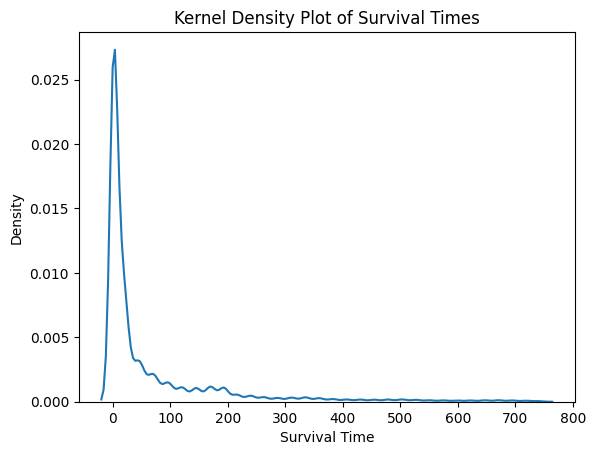

In [ ]:
import seaborn as sns

# Create a kernel density plot of survival times
sns.kdeplot(linear_y)
plt.title('Kernel Density Plot of Survival Times')
plt.xlabel('Survival Time')
plt.show()

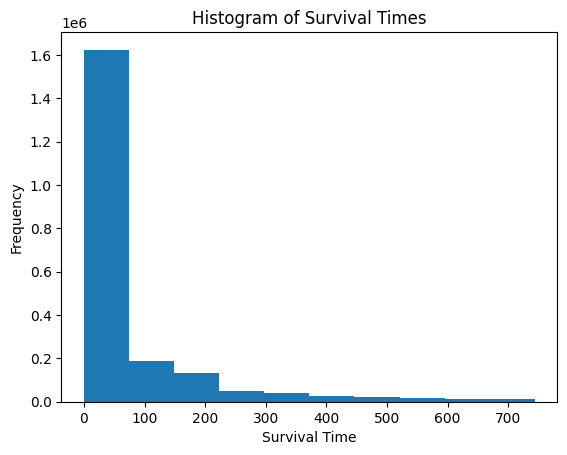

In [ ]:
plt.hist(linear_y, bins=10)
plt.title('Histogram of Survival Times')
plt.xlabel('Survival Time')
plt.ylabel('Frequency')
plt.show()

In [ ]:
linear_y.describe()

count    2.127214e+06
mean     6.609170e+01
std      1.233855e+02
min      0.000000e+00
25%      1.181667e+00
50%      1.361500e+01
75%      6.915743e+01
max      7.440000e+02
Name: survival_time_hours, dtype: float64

#### Summary Statistics for "Time to Close" Data

- **Count:** There are 2,323,546 non-missing values in the "time to close" column.

- **Mean:** The average time to close is 396.04 hours.

- **Standard Deviation:** The standard deviation of the time to close is 1,789.77 hours, which indicates that the values in the column are spread out quite a bit from the mean.

- **Minimum:** The smallest value in the column is -0.0161 hours, which is a negative value that might be an error in the data.

- **25th Percentile:** 25% of the cases had a "time to close" of 1.41 hours or less.

- **50th Percentile (Median):** 50% of the cases had a "time to close" of 17.09 hours or less, which is the median of the distribution.

- **75th Percentile:** 75% of the cases had a "time to close" of 117.67 hours or less.

- **Maximum:** The largest value in the column is 69,894.29 hours, which is a very long time and might indicate some outliers in the data.

Based on these summary statistics, it seems like the "time to close" data has a long-tailed distribution with a few very large values that are quite far from the mean and median values. 

Let's add a line of code to our linear regression clean data model that drops all records with a negative time to close or a time to close less than a month. 


In [ ]:
#Train a logistic regression model

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(logistic_X, logistic_y, test_size=0.2, random_state=42)

# Build model
model_logistic = keras.Sequential([
    keras.layers.Dense(units=1, input_shape=(X_train.shape[1],), activation='sigmoid')
])

# Compile model
model_logistic.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model_logistic.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate model
test_loss, test_acc = model_logistic.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

Let's train the linear regression model with fewer outliers and see what we get

In [ ]:
#Train a linear regression model

start_time = datetime.now()
print("Starting Training at {}".format(start_time))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(linear_X) # scale the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, linear_y, test_size=0.2, random_state=42)

# split the data again to create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# define the model architecture
model_linear = keras.Sequential([
    keras.layers.Dense(units=1, input_dim=X_train.shape[1])
])

# compile the model
model_linear.compile(optimizer='adam', loss='mean_squared_error')

# train the model
model_linear.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_val, y_val))

end_time = datetime.now()
total_time = (end_time - start_time)
print("Ending Training at {}".format(end_time))
print("Training took {}".format(total_time))

Starting Training at 2023-05-06 01:41:37.352991
Epoch 1/50
42545/42545 [==============================] - 89s 2ms/step - loss: 19433.4863 - val_loss: 52230.5195
Epoch 2/50
42545/42545 [==============================] - 85s 2ms/step - loss: 17488.3027 - val_loss: 114306.4688
Epoch 3/50
42545/42545 [==============================] - 85s 2ms/step - loss: 18207.8125 - val_loss: 130831.9688
Epoch 4/50
42545/42545 [==============================] - 101s 2ms/step - loss: 18311.7363 - val_loss: 133272.8281
Epoch 5/50
42545/42545 [==============================] - 86s 2ms/step - loss: 18295.9414 - val_loss: 133919.1719
Epoch 6/50
42545/42545 [==============================] - 88s 2ms/step - loss: 18257.9258 - val_loss: 133605.5938
Epoch 7/50
42545/42545 [==============================] - 86s 2ms/step - loss: 18214.2422 - val_loss: 133560.2656
Epoch 8/50
42545/42545 [==============================] - 87s 2ms/step - loss: 18164.9668 - val_loss: 133476.7031
Epoch 9/50
42545/42545 [================

In [ ]:
model_linear.save("model_linear.h5")

In [ ]:
model_logistic.save("model_logistic.h5")

We save these models so that we can start building a website and API to make these models available to the public